## LSTM based simulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from datetime import timedelta
from tensorflow.python.framework import ops as tf_ops
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
sns.set()
tf.compat.v1.random.set_random_seed(1234)

### Define global variables

In [3]:
csv_filepath:str = "../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv"
print(f"csv_filepath {csv_filepath}")
date_column:str = "Date "
low_column:str = "LOW "
high_column:str = "HIGH "
close_column:str = "close "

csv_filepath ../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv


### Read csv data

In [4]:
df = pd.read_csv(csv_filepath, header=0)
print(f"df keys {df.keys()}")
# Sort DataFrame by date
df[date_column]=pd.to_datetime(df[date_column])
df.head()

df keys Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2020-08-19,EQ,"1,835.00","1,835.90","1,818.05","1,820.70","1,827.55","1,827.95","1,828.01","2,499.90","1,473.45",2934730,"5,364,712,976.60",85358
1,2020-08-18,EQ,"1,801.10","1,825.40","1,795.95","1,800.55","1,819.05","1,820.70","1,813.53","2,499.90","1,473.45",3413536,"6,190,549,505.40",141811
2,2020-08-17,EQ,"1,805.00","1,807.85","1,783.85","1,791.70","1,801.95","1,800.55","1,795.17","2,499.90","1,473.45",4076960,"7,318,829,944.15",148103
3,2020-08-14,EQ,"1,818.60","1,823.75","1,773.25","1,804.85","1,793.75","1,791.70","1,796.65","2,499.90","1,473.45",6136766,"11,025,637,096.85",186319
4,2020-08-13,EQ,"1,818.50","1,823.65","1,799.55","1,814.20","1,810.00","1,804.85","1,807.52","2,499.90","1,473.45",3769538,"6,813,503,042.60",129725


In [5]:
df[date_column] = df[date_column].astype('datetime64[ns]')
df[low_column] = df[low_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[high_column] = df[high_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[close_column] = df[close_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df = df.sort_values(by=[date_column], ascending=True)
df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
485,2018-08-29,EQ,"1,959.40",1971.40,1944.70,"1,955.15","1,949.00",1956.25,"1,958.79","2,052.95","1,638.00",2367281,"4,636,999,492.95",106131
484,2018-08-30,EQ,"1,950.00",1964.45,1928.25,"1,956.25","1,933.00",1934.15,"1,938.39","2,052.95","1,638.00",2466442,"4,780,934,933.15",89377
483,2018-08-31,EQ,"1,940.90",1942.45,1908.05,"1,934.15","1,940.85",1935.95,"1,925.82","2,052.95","1,638.00",3856093,"7,426,153,067.50",152636
482,2018-09-03,EQ,"1,950.00",1950.00,1928.10,"1,935.95","1,943.00",1944.80,"1,939.87","2,052.95","1,638.00",2310201,"4,481,480,074.20",106865
481,2018-09-04,EQ,"1,939.00",1959.65,1939.00,"1,944.80","1,950.75",1954.80,"1,952.12","2,052.95","1,638.00",2928533,"5,716,834,403.55",133601


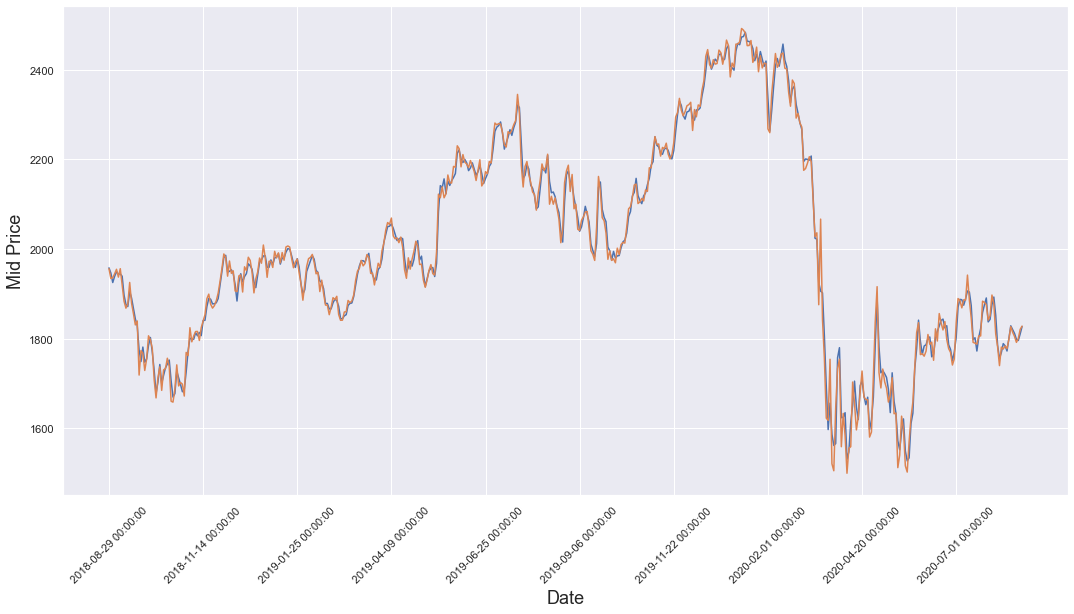

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df[low_column]+df[high_column])/2.0)
plt.plot(range(df.shape[0]),(df[close_column]))
plt.xticks(range(0,df.shape[0],50),df[date_column].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [7]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.472029
1,0.455552
2,0.435318
3,0.455401
4,0.466320


## Split train and test

I will cut the dataset to train and test datasets,

    - Train dataset derived from starting timestamp until last 30 days
    - Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [8]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((486, 14), (456, 1), (30, 1))

In [9]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


In [10]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [11]:
def forecast():
    tf_ops.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [12]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
accuracies = [calculate_accuracy(df[close_column].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df[close_column].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()
